In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import ParameterGrid

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils.ae_eval_and_vis import *
#from utils.ae_torch_classes import *
from utils.ae_V2_dropout import *

# Load in Data

In [2]:
from utils.data_loading_paths import *

kai_laptop = True
brc_desktop = False

if kai_laptop:
    data_path = kai_data_path
    model_dir_path = kai_model_dir_path
    metadata_path = kai_metadata_path
elif brc_desktop:
    data_path = brc_data_path
    model_dir_path = brc_model_dir_path
    metadata_path = brc_metadata_path

metadata_cols_df = pd.read_pickle(metadata_path)

# Dropping the metadata when we read it in!
training_u_df = pd.read_pickle(data_path+emg_dir+'training_users_df.pkl').drop(metadata_cols, axis=1)
test_users_df = pd.read_pickle(data_path+emg_dir+'test_users_df.pkl').drop(metadata_cols, axis=1)

In [3]:
print(training_u_df.shape)
training_u_df.head()

(160000, 16)


,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,-0.362743,-0.801651,-0.383077,-0.195299,-0.203047,-0.464472,-0.276292,-0.026736,-0.873870,-1.036152,-0.580930,-0.719494,-0.502255,-1.750091,-0.127847,-0.094192
1,-0.351553,-0.775334,-0.382545,-0.154773,-0.131977,-0.295204,-0.125822,0.089679,-0.816215,-2.082635,-0.006283,-0.139439,-0.367764,-0.208084,-0.111811,-0.039009
2,-0.380825,-0.762588,-0.398388,-0.085411,0.017528,-0.205675,-0.068451,0.117076,-0.668221,-3.403064,-0.526030,-0.478294,-0.300443,0.203266,0.113300,0.004728
3,-0.366795,-0.765464,-0.374423,-0.073225,0.183172,0.009277,-0.058907,0.080977,-0.424416,-3.709413,-0.570894,-0.775155,-0.144710,-0.619539,0.146499,0.199975
4,-0.245578,-0.761283,-0.303976,-0.081947,0.224996,0.103319,-0.003929,0.041526,-0.016530,-4.075150,-0.127710,2.682791,-0.141750,-0.208404,-0.035642,0.172662


In [4]:
# CREATE THE TRAINING SET
num_rows_per_gesture = 64 # From the interp
num_gestures = len(training_u_df) // num_rows_per_gesture
num_features = training_u_df.shape[1]

# Ensure the data can be evenly divided into gestures
assert len(training_u_df) % num_rows_per_gesture == 0, "The total number of rows is not a multiple of the number of rows per gesture."

# Reshape into (batch_dim, time_step, n_features) AKA (n_gestures, n_rows_per_gesture, n_columns)
X_3D_PCA40 = training_u_df.to_numpy().reshape(num_gestures, num_rows_per_gesture, num_features)
#flattened_PCA = PCA_np.reshape(num_gestures, -1)

# Convert to PyTorch tensor
X_3DTensor_PCA40 = torch.tensor(X_3D_PCA40, dtype=torch.float32)

# Dummy dataset
#data = torch.randn(num_gestures, timesteps, num_features)
#dataset = TensorDataset(data)
#data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Create the dataset
u_training_dataset = GestureDatasetAE(X_3DTensor_PCA40)

batch_size = 32  # Adjust batch size as needed
train_loader = DataLoader(u_training_dataset, batch_size=batch_size, shuffle=True) # Should shuffle be False? 
## It's shuffling the gesture order I think so that should be fine...

# CREATE THE TEST SET
num_test_gestures = len(test_users_df) // num_rows_per_gesture
# Ensure the data can be evenly divided into gestures
assert len(test_users_df) % num_rows_per_gesture == 0, "The total number of rows is not a multiple of the number of rows per gesture."

# Reshape into (batch_dim, time_step, n_features) AKA (n_gestures, n_rows_per_gesture, n_columns) and convert to torch tensor
## Theres probably an easier way to just create it as a torch tensor lol
Xtest_3DTensor_PCA40 = torch.tensor(test_users_df.to_numpy().reshape(num_test_gestures, num_rows_per_gesture, num_features), dtype=torch.float32)

# Create the dataset
u_testing_dataset = GestureDatasetAE(Xtest_3DTensor_PCA40)
test_loader = DataLoader(u_testing_dataset, batch_size=batch_size, shuffle=False)

# RNN Autoencoder

In [5]:
# Example usage
input_dim = 16
#num_features = 40
seq_len = 64
#timesteps = 64
criterion = nn.MSELoss()
num_epochs = 10

## Finding good 2D and 3D AE architectures

Started
Epoch 0: Train Loss: 1.1030439621285548;  Validation Loss: 1.0226079388098284
Epoch 1: Train Loss: 1.0171047909350335;  Validation Loss: 0.959183397618207
Epoch 2: Train Loss: 0.9660640841797937;  Validation Loss: 0.9026438404213298
Epoch 3: Train Loss: 0.9257317592826071;  Validation Loss: 0.8550416041504253
Epoch 4: Train Loss: 0.8944302344624;  Validation Loss: 0.820502988316796
Epoch 5: Train Loss: 0.870603123797646;  Validation Loss: 0.7934071611274373
Epoch 6: Train Loss: 0.8503809676894659;  Validation Loss: 0.7690789211880077
Epoch 7: Train Loss: 0.8320985700510726;  Validation Loss: 0.7454594454982064
Epoch 8: Train Loss: 0.8138715436186972;  Validation Loss: 0.7229940809986808
Epoch 9: Train Loss: 0.8020281037197837;  Validation Loss: 0.7018781710754741


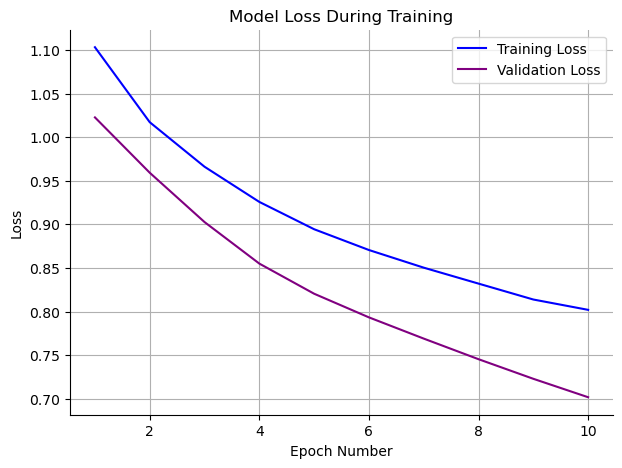

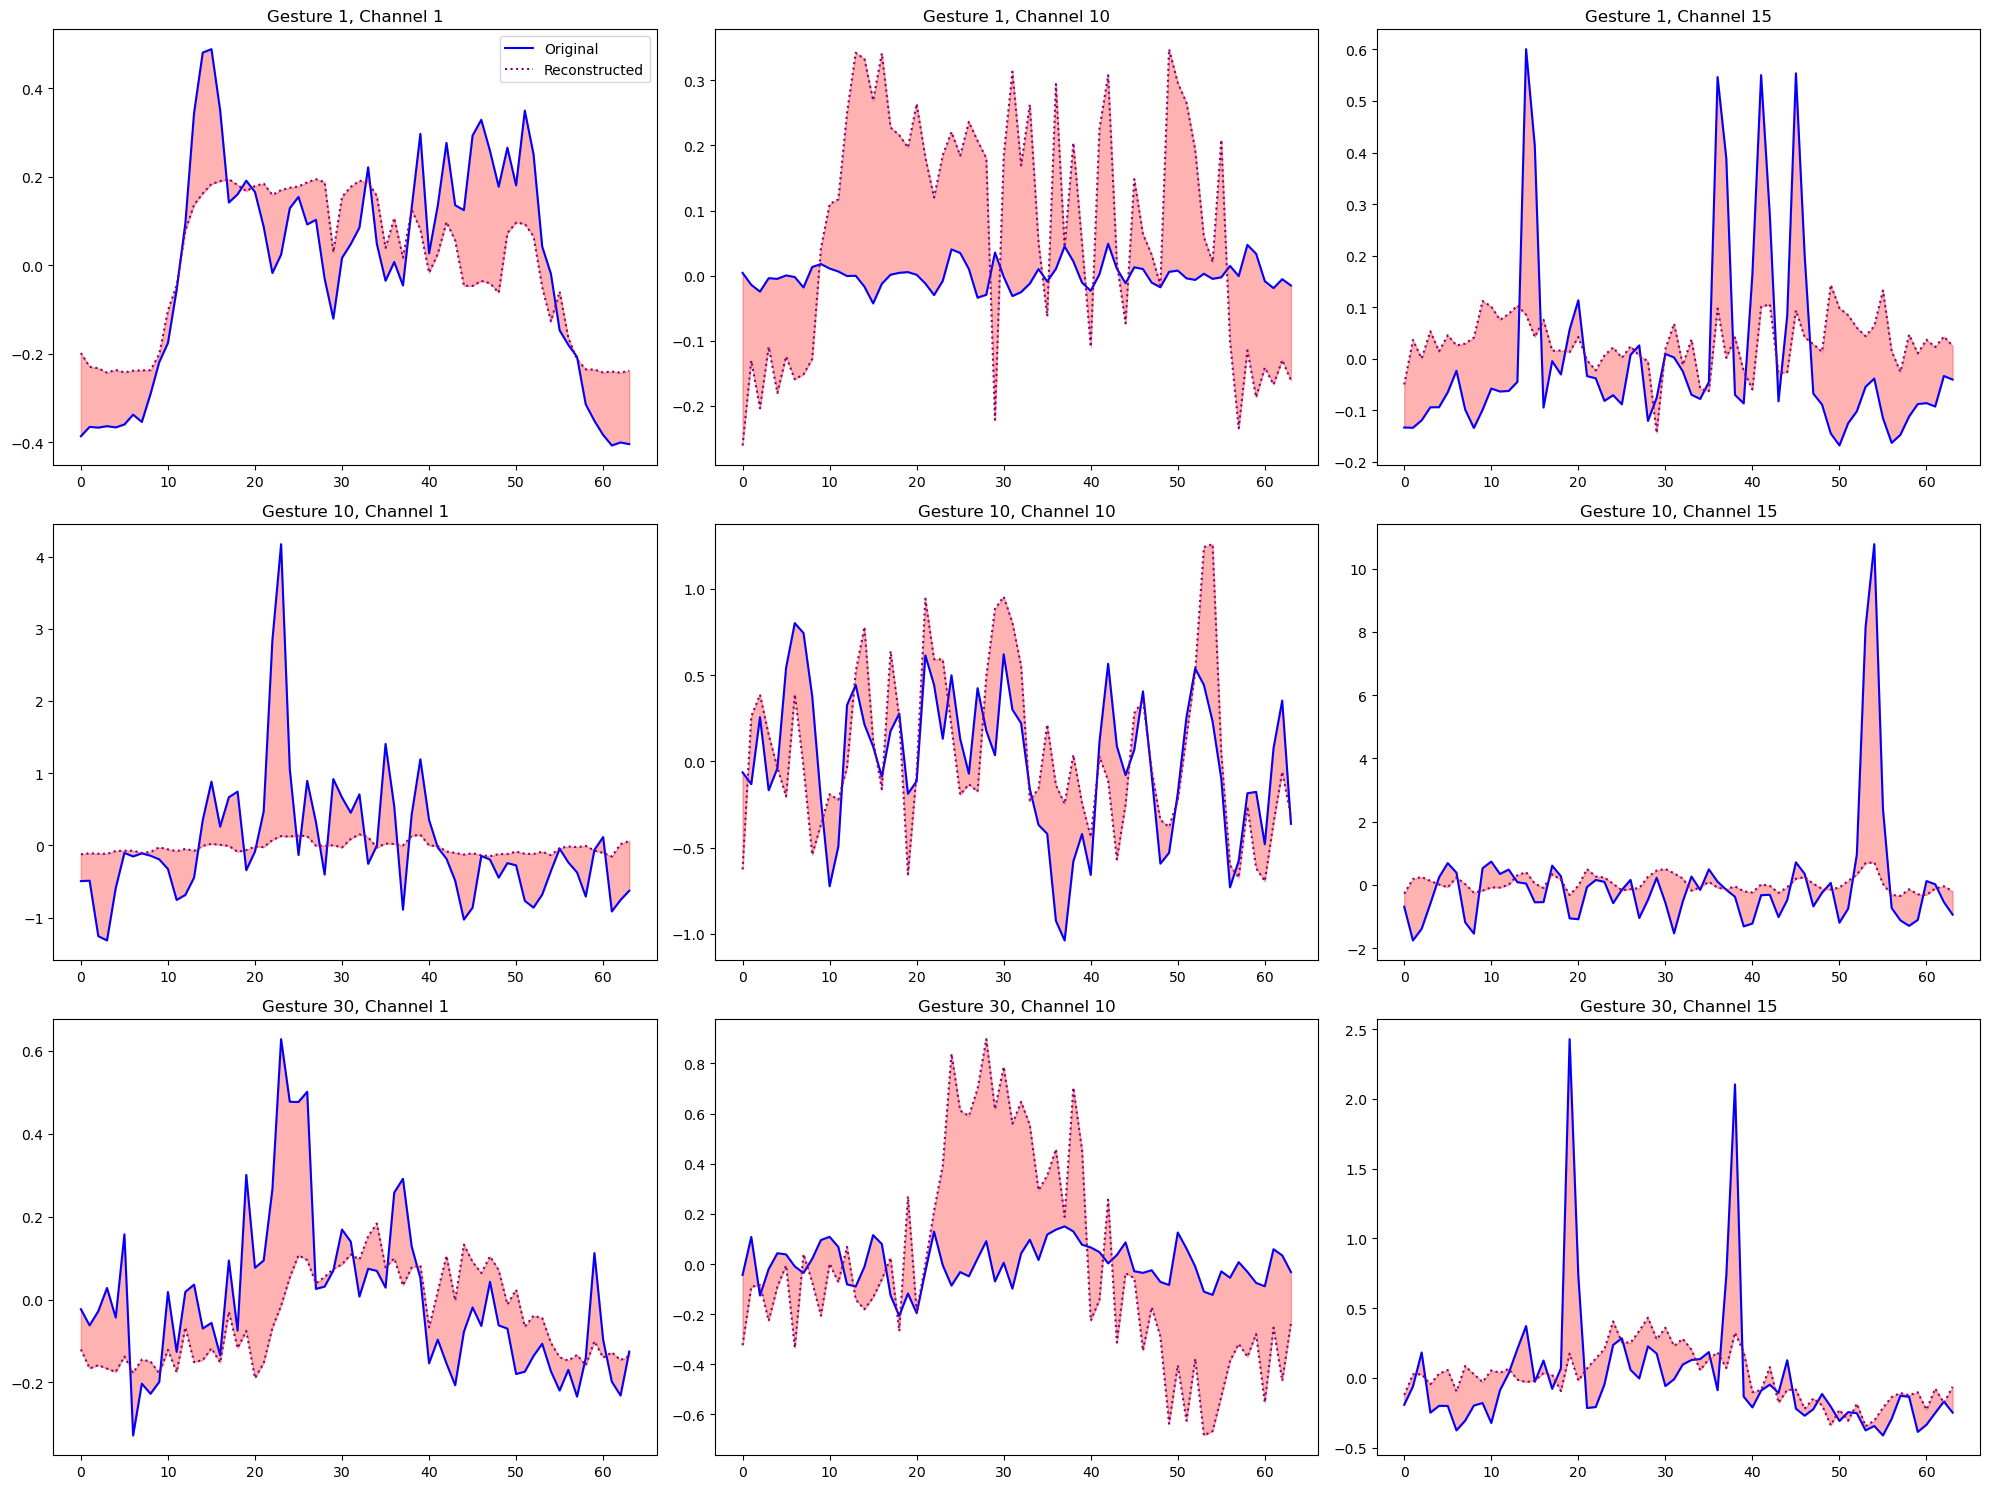

In [33]:
print("Started")

# Hyperparameters and dataset setup
num_layers = None
lr = 0.001
hidden_dim_list = [3]

# With mirroring
model_3mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

test_batch0 = next(iter(test_loader))
reconstruct_testbatch0 = model_3mir.forward(test_batch0).detach().numpy()

visualize_original_vs_reconstructed_gestures(test_batch0, reconstruct_testbatch0, selected_channels=[1,10,15]) #selected_gestures,

Started
Epoch 0: Train Loss: 1.0117823496649536;  Validation Loss: 0.9396966885436665
Epoch 1: Train Loss: 0.9269865698452238;  Validation Loss: 0.8046273372390054
Epoch 2: Train Loss: 0.882321402241912;  Validation Loss: 0.7755732482129877
Epoch 3: Train Loss: 0.8641175627708435;  Validation Loss: 0.7561645209789276
Epoch 4: Train Loss: 0.8529285909254339;  Validation Loss: 0.7456531660123304
Epoch 5: Train Loss: 0.8446237588230567;  Validation Loss: 0.7376582514155995
Epoch 6: Train Loss: 0.8372833449629289;  Validation Loss: 0.7316809350794012
Epoch 7: Train Loss: 0.8328637978698634;  Validation Loss: 0.727734699845314
Epoch 8: Train Loss: 0.8297207083883165;  Validation Loss: 0.7234505238858137
Epoch 9: Train Loss: 0.8244183048417296;  Validation Loss: 0.7203065346587788


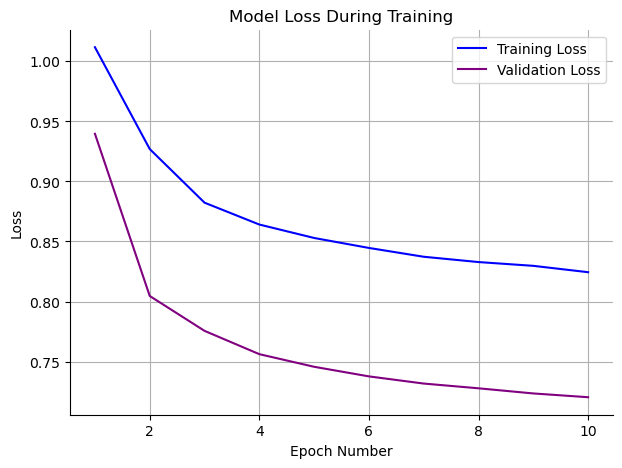

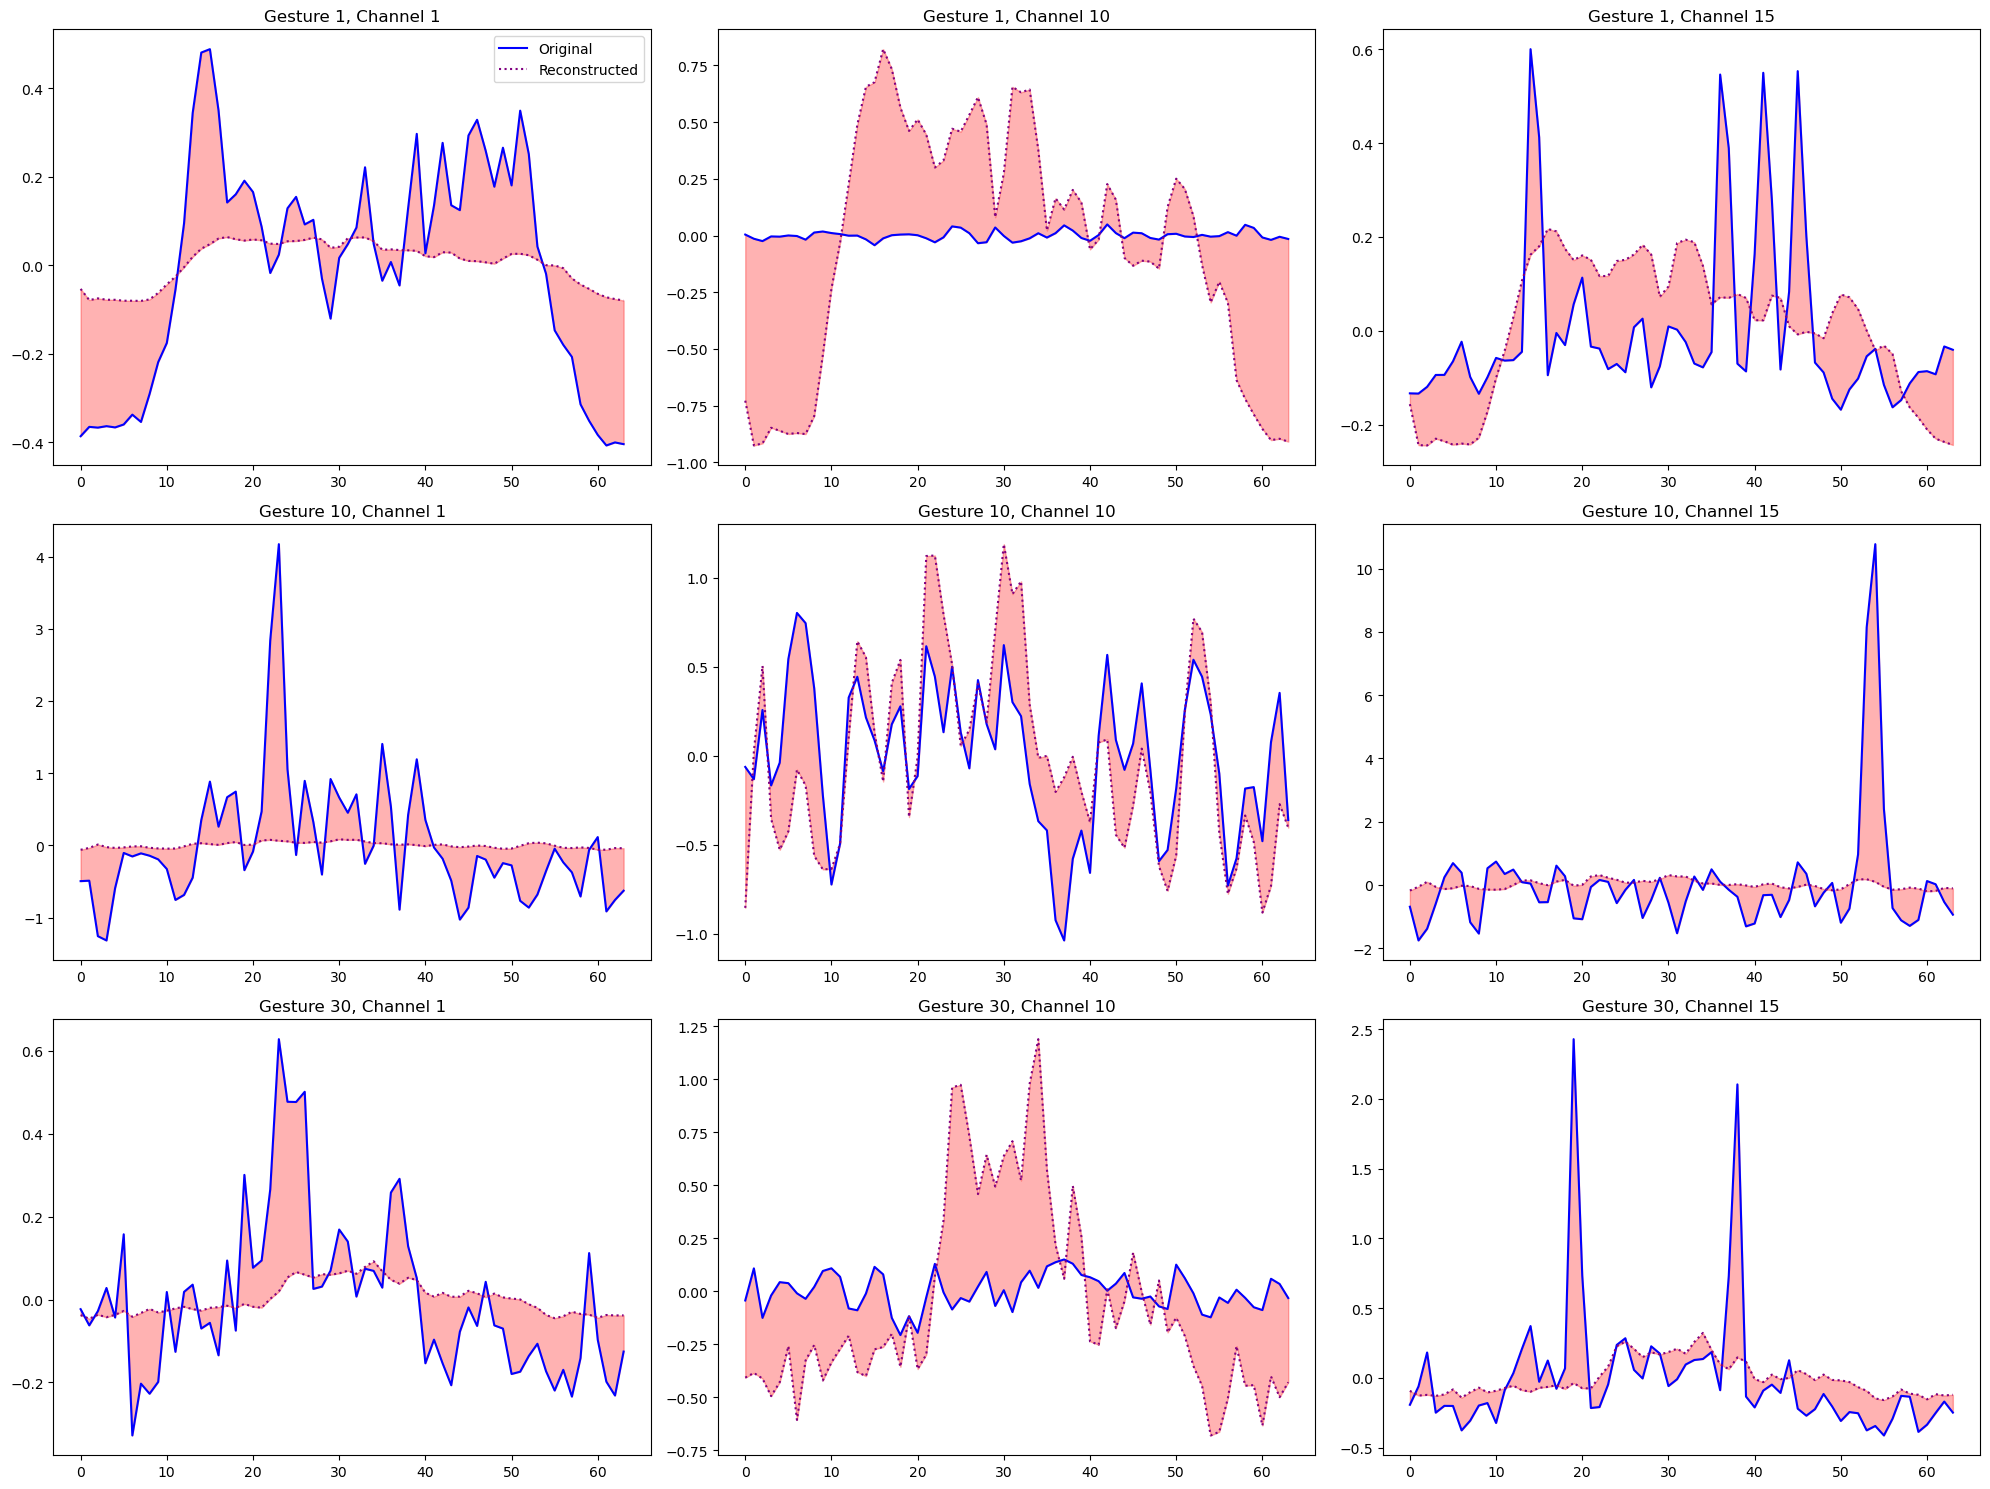

In [35]:
print("Started")

# Hyperparameters and dataset setup
num_layers = None
lr = 0.001
hidden_dim_list = [14, 10, 5, 3]

# With mirroring
model_14_10_5_3mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

test_batch0 = next(iter(test_loader))
reconstruct_testbatch0 = model_14_10_5_3mir.forward(test_batch0).detach().numpy()

visualize_original_vs_reconstructed_gestures(test_batch0, reconstruct_testbatch0, selected_channels=[1,10,15]) #selected_gestures,

Started
Epoch 0: Train Loss: 0.9703526534611666;  Validation Loss: 0.839182970198718
Epoch 1: Train Loss: 0.887941309168369;  Validation Loss: 0.7805979414419695
Epoch 2: Train Loss: 0.8635665819614748;  Validation Loss: 0.7596078487959775
Epoch 3: Train Loss: 0.851269552224799;  Validation Loss: 0.7478961294347589
Epoch 4: Train Loss: 0.8397777261613291;  Validation Loss: 0.7383961352435026
Epoch 5: Train Loss: 0.830476346649701;  Validation Loss: 0.7303427376530387
Epoch 6: Train Loss: 0.8249709515631953;  Validation Loss: 0.7253924242474816
Epoch 7: Train Loss: 0.8192012310028076;  Validation Loss: 0.7184275659647855
Epoch 8: Train Loss: 0.8143877839740319;  Validation Loss: 0.7154198261824521
Epoch 9: Train Loss: 0.808709221550181;  Validation Loss: 0.7098216278986498


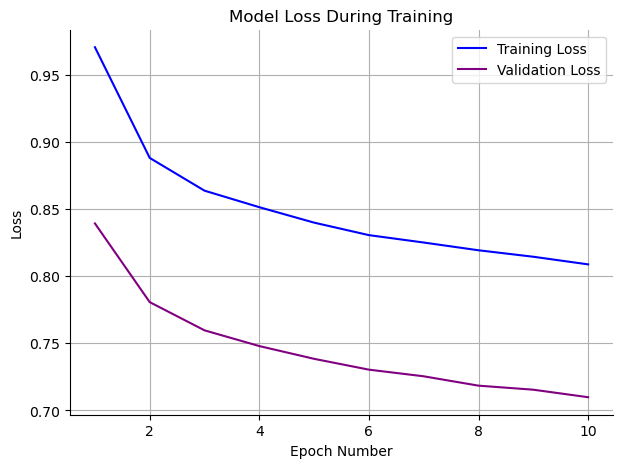

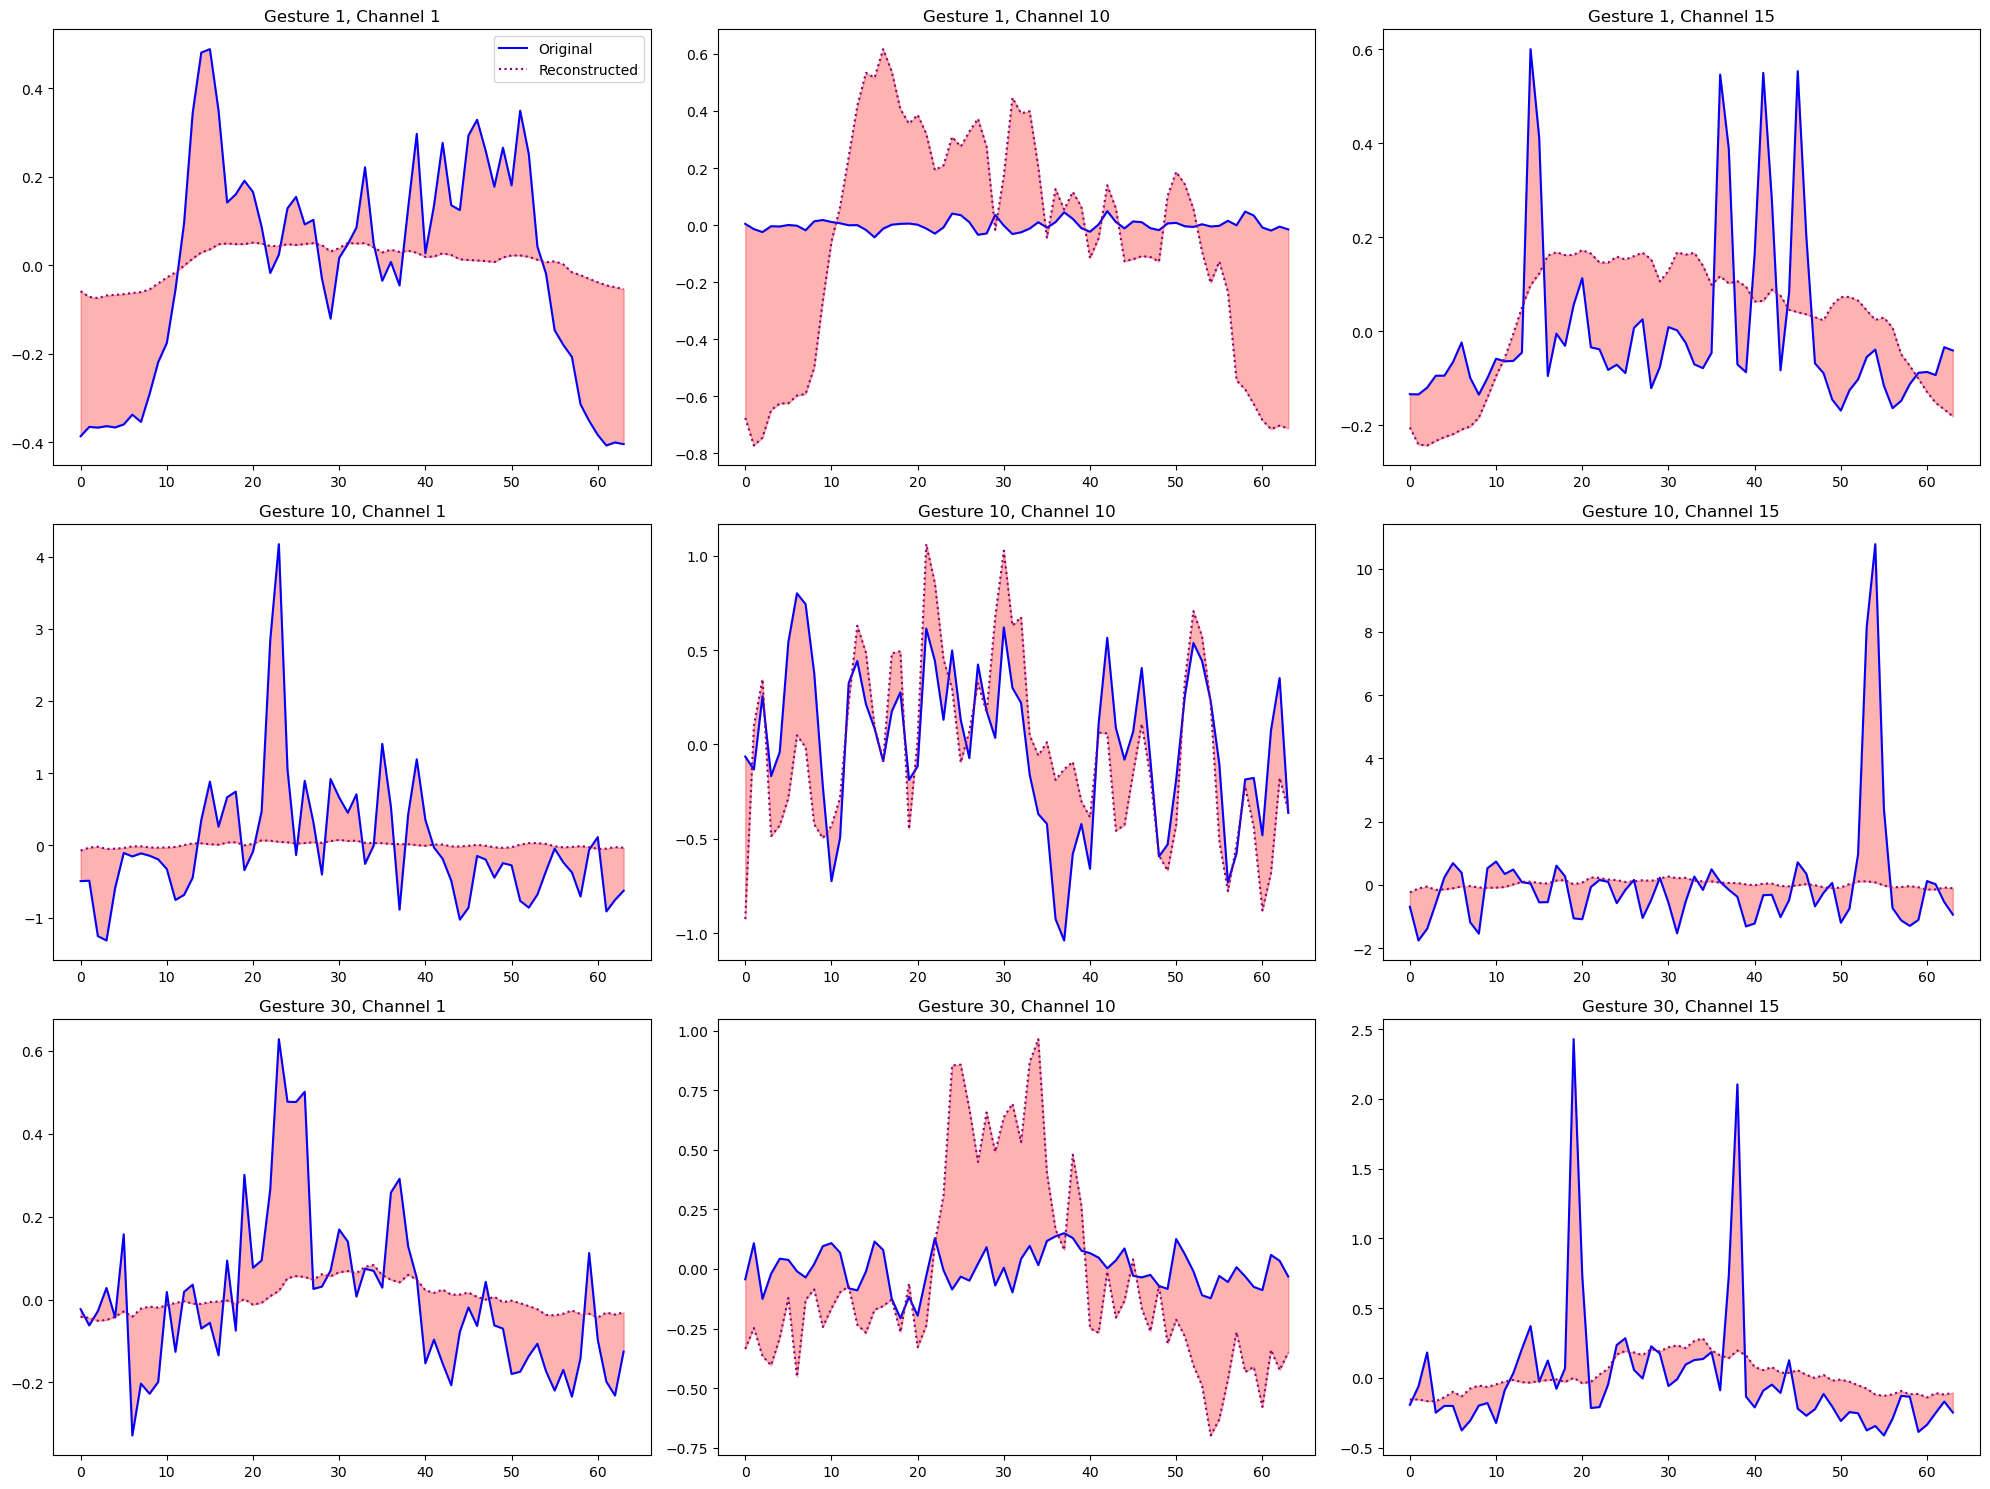

In [34]:
print("Started")

# Hyperparameters and dataset setup
num_layers = None
lr = 0.001
hidden_dim_list = [18, 8, 3]

# With mirroring
model_18_8_3mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

test_batch0 = next(iter(test_loader))
reconstruct_testbatch0 = model_18_8_3mir.forward(test_batch0).detach().numpy()

visualize_original_vs_reconstructed_gestures(test_batch0, reconstruct_testbatch0, selected_channels=[1,10,15]) #selected_gestures,

Yah none of these are stunning but I'll just save one anyways...

In [36]:
not_saved = False

if not_saved:
    torch.save(model_18_8_3mir .state_dict(), model_dir_path+'RNNAE_18_8_3mir_dropp25_vallossp540_EMGFull.pth')


## Manual Grid Search

Started
Epoch 0: Train Loss: 0.9742202517352526;  Validation Loss: 0.8504281965169039
Epoch 1: Train Loss: 0.8520233902750136;  Validation Loss: 0.6886539743705229
Epoch 2: Train Loss: 0.7877974215942093;  Validation Loss: 0.6429805891080336
Epoch 3: Train Loss: 0.7624867452850824;  Validation Loss: 0.6243267005140131
Epoch 4: Train Loss: 0.750828002827077;  Validation Loss: 0.6107493435794656
Epoch 5: Train Loss: 0.7398707761040216;  Validation Loss: 0.6008183712309058
Epoch 6: Train Loss: 0.7332178112826769;  Validation Loss: 0.5926055745645002
Epoch 7: Train Loss: 0.7286038278024408;  Validation Loss: 0.5882411870089445
Epoch 8: Train Loss: 0.7230207105226154;  Validation Loss: 0.5827969353307377
Epoch 9: Train Loss: 0.7216057347345955;  Validation Loss: 0.5784289620139382


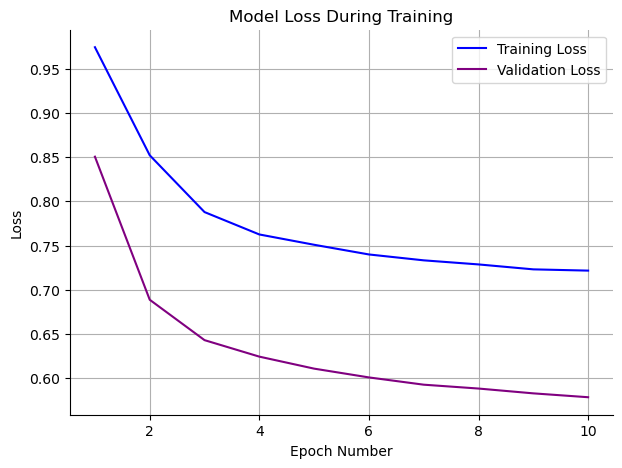

In [6]:
print("Started")

# Hyperparameters and dataset setup
num_layers = 3
lr = 0.001
hidden_dim = 16

# With progressive halving
model_16_nl3_prog, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim, num_layers, train_loader, test_loader, progressive_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.9965442456776583;  Validation Loss: 0.9111333624883131
Epoch 1: Train Loss: 0.8852305970614469;  Validation Loss: 0.7083579870787534
Epoch 2: Train Loss: 0.8037482907500448;  Validation Loss: 0.6467130292545665
Epoch 3: Train Loss: 0.7766536994825436;  Validation Loss: 0.6229016713120721
Epoch 4: Train Loss: 0.7615178710297693;  Validation Loss: 0.6111046739599921
Epoch 5: Train Loss: 0.7501197585576698;  Validation Loss: 0.60262331366539
Epoch 6: Train Loss: 0.7441660958000377;  Validation Loss: 0.595215537331321
Epoch 7: Train Loss: 0.7390556463712379;  Validation Loss: 0.5921861326152628
Epoch 8: Train Loss: 0.7351258774346943;  Validation Loss: 0.5889290977608074
Epoch 9: Train Loss: 0.7327414932130258;  Validation Loss: 0.5847788967869498


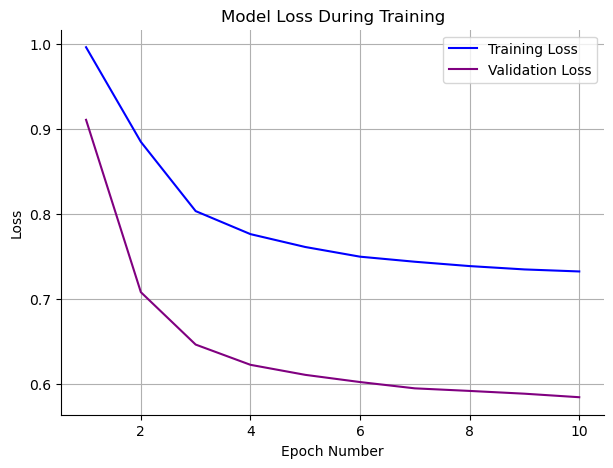

In [7]:
print("Started")

# Hyperparameters and dataset setup
num_layers = None
lr = 0.001
hidden_dim_list = [16, 8, 4]

# With mirroring
model_16_8_4mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 1.0114657592169847;  Validation Loss: 0.933763555505059
Epoch 1: Train Loss: 0.8931143653543689;  Validation Loss: 0.7336912751197815
Epoch 2: Train Loss: 0.8170552630967731;  Validation Loss: 0.6666126684709028
Epoch 3: Train Loss: 0.791820539703852;  Validation Loss: 0.6424130187793211
Epoch 4: Train Loss: 0.7760678748541241;  Validation Loss: 0.6253704144196077
Epoch 5: Train Loss: 0.7606925481482397;  Validation Loss: 0.6149412325837396
Epoch 6: Train Loss: 0.7561358545399919;  Validation Loss: 0.6062209538438104
Epoch 7: Train Loss: 0.7498120341119887;  Validation Loss: 0.601114347577095
Epoch 8: Train Loss: 0.7460274786888799;  Validation Loss: 0.5948451066559012
Epoch 9: Train Loss: 0.7448814632017401;  Validation Loss: 0.5915921465917067


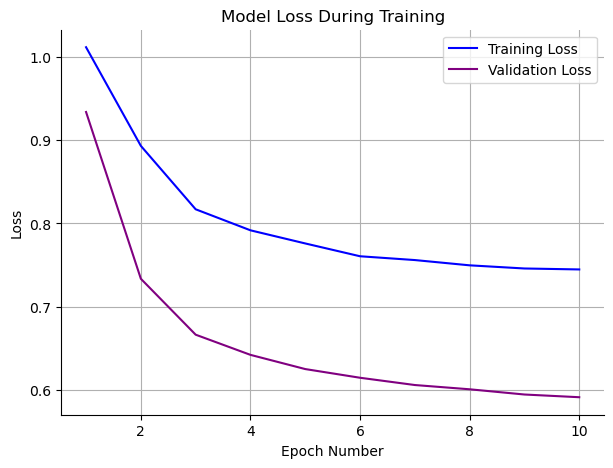

In [8]:
print("Started")

# Hyperparameters and dataset setup
num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [16, 8, 3]
model_16_8_3mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.9841841504543642;  Validation Loss: 0.899615309455178
Epoch 1: Train Loss: 0.9189608081986632;  Validation Loss: 0.8415091742168773
Epoch 2: Train Loss: 0.8816737811776656;  Validation Loss: 0.7614712092009458
Epoch 3: Train Loss: 0.8482700782486156;  Validation Loss: 0.7344195734370839
Epoch 4: Train Loss: 0.8329736944995348;  Validation Loss: 0.7242734107104215
Epoch 5: Train Loss: 0.8220275059531007;  Validation Loss: 0.7095913182605397
Epoch 6: Train Loss: 0.811543276038351;  Validation Loss: 0.7070381505922838
Epoch 7: Train Loss: 0.8069310022305839;  Validation Loss: 0.6991008113731038
Epoch 8: Train Loss: 0.7990994347801691;  Validation Loss: 0.6951740614392541
Epoch 9: Train Loss: 0.7956827147097527;  Validation Loss: 0.691092848777771


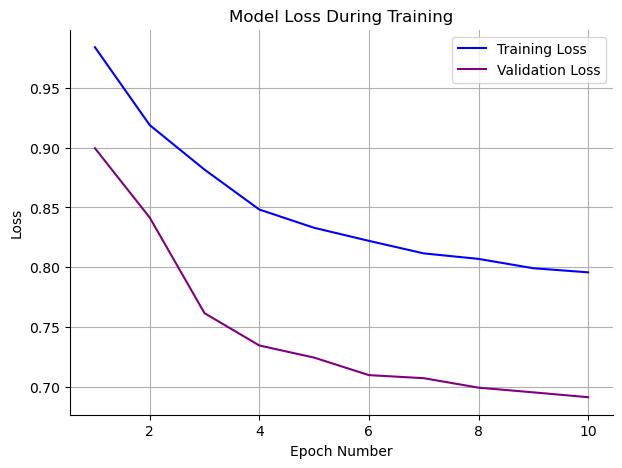

In [9]:
print("Started")

# Hyperparameters and dataset setup
num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [20, 14, 7, 3]
model_20_14_7_3mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.9794190239302719;  Validation Loss: 0.831983969970183
Epoch 1: Train Loss: 0.7979025508784041;  Validation Loss: 0.6523101519454609
Epoch 2: Train Loss: 0.6943570760231984;  Validation Loss: 0.5551284050399606
Epoch 3: Train Loss: 0.6313317040853863;  Validation Loss: 0.49298640950159595
Epoch 4: Train Loss: 0.5865696661079987;  Validation Loss: 0.4503438987515189
Epoch 5: Train Loss: 0.5561336954183216;  Validation Loss: 0.41889552636580035
Epoch 6: Train Loss: 0.5328214466571808;  Validation Loss: 0.39321310818195343
Epoch 7: Train Loss: 0.5163987388339224;  Validation Loss: 0.3687513904138045
Epoch 8: Train Loss: 0.5013671758808668;  Validation Loss: 0.3482840420170264
Epoch 9: Train Loss: 0.4922769511047798;  Validation Loss: 0.3340947208079425


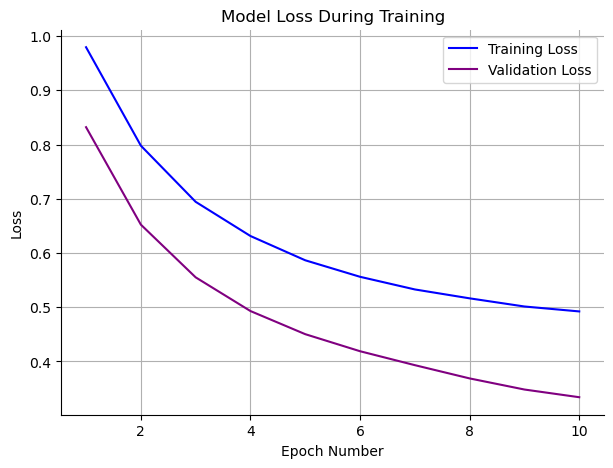

In [10]:
print("Started")

num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [10]
model_10mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.9966206135629099;  Validation Loss: 0.840162989768115
Epoch 1: Train Loss: 0.8257885009427613;  Validation Loss: 0.6738235842097889
Epoch 2: Train Loss: 0.7195699041402792;  Validation Loss: 0.5661808834834532
Epoch 3: Train Loss: 0.6593263813211948;  Validation Loss: 0.5031530545516447
Epoch 4: Train Loss: 0.6198185418225541;  Validation Loss: 0.4576250910758972
Epoch 5: Train Loss: 0.5903075752379019;  Validation Loss: 0.4249000021002509
Epoch 6: Train Loss: 0.5696353765228127;  Validation Loss: 0.4016563309864564
Epoch 7: Train Loss: 0.55185633784608;  Validation Loss: 0.38561498712409625
Epoch 8: Train Loss: 0.5359322247625906;  Validation Loss: 0.371594327417287
Epoch 9: Train Loss: 0.5261812402477747;  Validation Loss: 0.3608911409974098


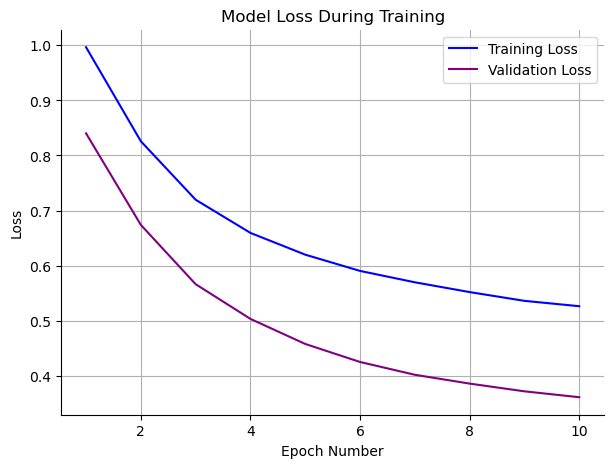

In [11]:
print("Started")

num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [9]
model_9mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.9901707096944882;  Validation Loss: 0.8267810507254167
Epoch 1: Train Loss: 0.8428615399553806;  Validation Loss: 0.6994203166528181
Epoch 2: Train Loss: 0.7568551332135743;  Validation Loss: 0.6235712685368278
Epoch 3: Train Loss: 0.70221094391014;  Validation Loss: 0.5735069553960453
Epoch 4: Train Loss: 0.6627532432350931;  Validation Loss: 0.5369023030454462
Epoch 5: Train Loss: 0.6322625920742373;  Validation Loss: 0.5077914974906228
Epoch 6: Train Loss: 0.6097571495213087;  Validation Loss: 0.48611295087770984
Epoch 7: Train Loss: 0.5925665437420712;  Validation Loss: 0.4693510342728008
Epoch 8: Train Loss: 0.5781779055353962;  Validation Loss: 0.45506947487592697
Epoch 9: Train Loss: 0.5718887425676177;  Validation Loss: 0.44238812747326767


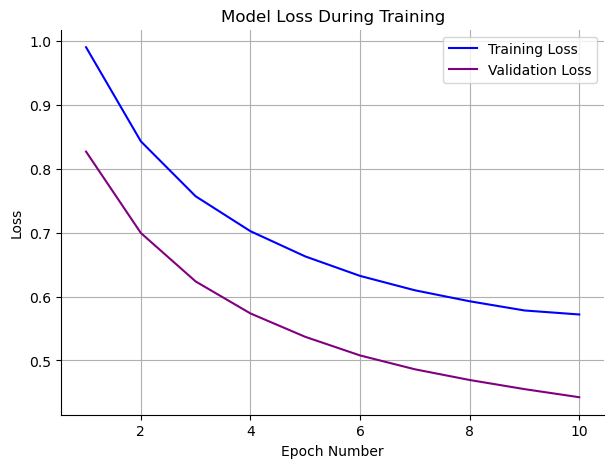

In [12]:
print("Started")

num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [8]
model_8mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 1.0115976258169246;  Validation Loss: 0.9137171100486409
Epoch 1: Train Loss: 0.9225682774676552;  Validation Loss: 0.8069029423323545
Epoch 2: Train Loss: 0.8883705169339723;  Validation Loss: 0.7976521416143938
Epoch 3: Train Loss: 0.879485002046899;  Validation Loss: 0.798304248939861
Epoch 4: Train Loss: 0.8731993383999113;  Validation Loss: 0.7924857681447809
Epoch 5: Train Loss: 0.8670071303089962;  Validation Loss: 0.790619199926203
Epoch 6: Train Loss: 0.8641339532936676;  Validation Loss: 0.7889334749091755
Epoch 7: Train Loss: 0.8570973284636871;  Validation Loss: 0.7827836573123932
Epoch 8: Train Loss: 0.8535018186025982;  Validation Loss: 0.7738598178733479
Epoch 9: Train Loss: 0.8487475725668895;  Validation Loss: 0.7663521793755618


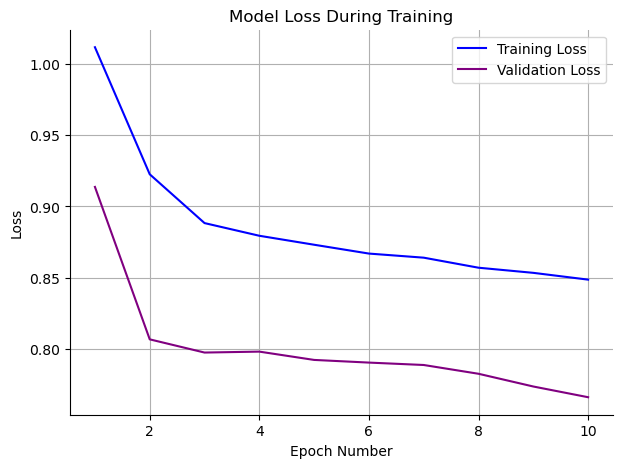

In [13]:
print("Started")

num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [17, 15, 13, 11, 9, 7, 5, 3]
model_17_15_13_11_9_7_5_3mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.9473008558719973;  Validation Loss: 0.7636444731192156
Epoch 1: Train Loss: 0.8092848266227336;  Validation Loss: 0.6431037228215825
Epoch 2: Train Loss: 0.7627453547489794;  Validation Loss: 0.6187040236863223
Epoch 3: Train Loss: 0.7440129759945447;  Validation Loss: 0.6015856794335626
Epoch 4: Train Loss: 0.7316811461991901;  Validation Loss: 0.5943392041054639
Epoch 5: Train Loss: 0.719385339489466;  Validation Loss: 0.586029357530854
Epoch 6: Train Loss: 0.7164655176899101;  Validation Loss: 0.5807443437251177
Epoch 7: Train Loss: 0.7133571332014059;  Validation Loss: 0.5782037621194666
Epoch 8: Train Loss: 0.7082761050779608;  Validation Loss: 0.5744941464879296
Epoch 9: Train Loss: 0.7059996135627167;  Validation Loss: 0.5713397427038713


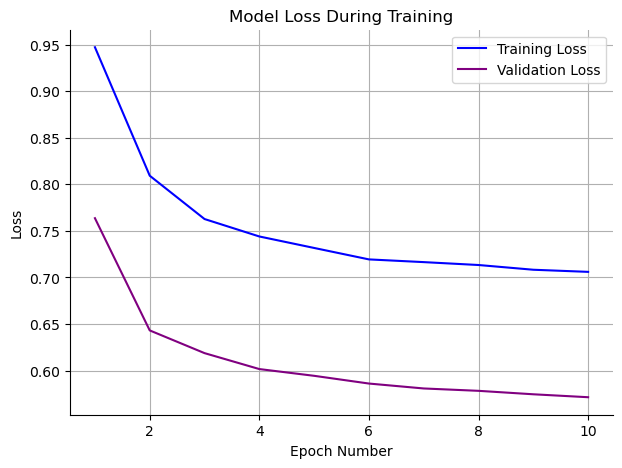

In [14]:
print("Started")

num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [18, 12, 8]
model_18_12_8mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 1.0015063451815256;  Validation Loss: 0.9067834561521356
Epoch 1: Train Loss: 0.8973196148872375;  Validation Loss: 0.741156973622062
Epoch 2: Train Loss: 0.8151359897625597;  Validation Loss: 0.6638636643236334
Epoch 3: Train Loss: 0.7807438147218921;  Validation Loss: 0.6379226784814488
Epoch 4: Train Loss: 0.7626778573929509;  Validation Loss: 0.6240049654787237
Epoch 5: Train Loss: 0.7488661310340785;  Validation Loss: 0.6121425371278416
Epoch 6: Train Loss: 0.7383168898051298;  Validation Loss: 0.60258879580281
Epoch 7: Train Loss: 0.7274276689638065;  Validation Loss: 0.5885315090417862
Epoch 8: Train Loss: 0.7215042008629328;  Validation Loss: 0.5700020654634996
Epoch 9: Train Loss: 0.7104000011576882;  Validation Loss: 0.5527746054259214


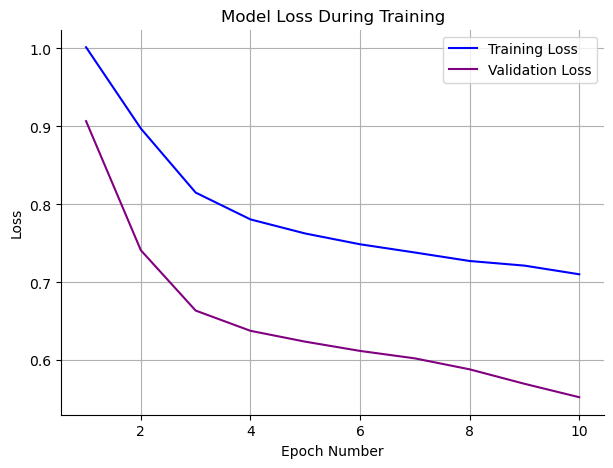

In [15]:
print("Started")

num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [8, 6]
model_8_6mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.9903801777694798;  Validation Loss: 0.8779492026025598
Epoch 1: Train Loss: 0.8530437327638457;  Validation Loss: 0.7152108929374001
Epoch 2: Train Loss: 0.7840853476826148;  Validation Loss: 0.650721325115724
Epoch 3: Train Loss: 0.7546364657486542;  Validation Loss: 0.6265530003742739
Epoch 4: Train Loss: 0.7402112310445761;  Validation Loss: 0.6110971962863748
Epoch 5: Train Loss: 0.7276270978058441;  Validation Loss: 0.6023418361490424
Epoch 6: Train Loss: 0.721272725847703;  Validation Loss: 0.5957070643251593
Epoch 7: Train Loss: 0.7154325148727321;  Validation Loss: 0.5907596891576593
Epoch 8: Train Loss: 0.7121712799313702;  Validation Loss: 0.5865653942931782
Epoch 9: Train Loss: 0.7109735698639592;  Validation Loss: 0.5849535925821825


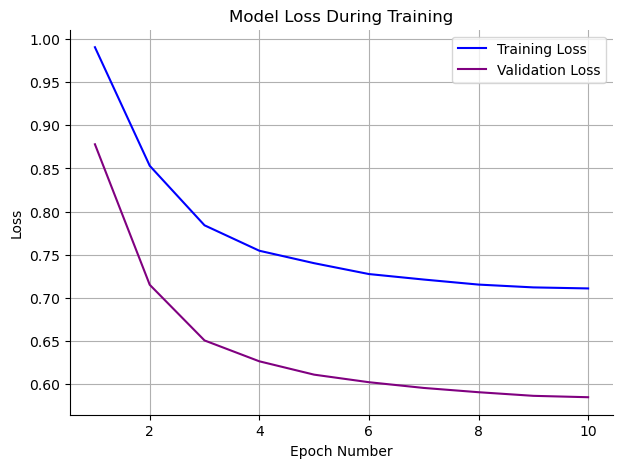

In [16]:
print("Started")

num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [12, 6]
model_12_6mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

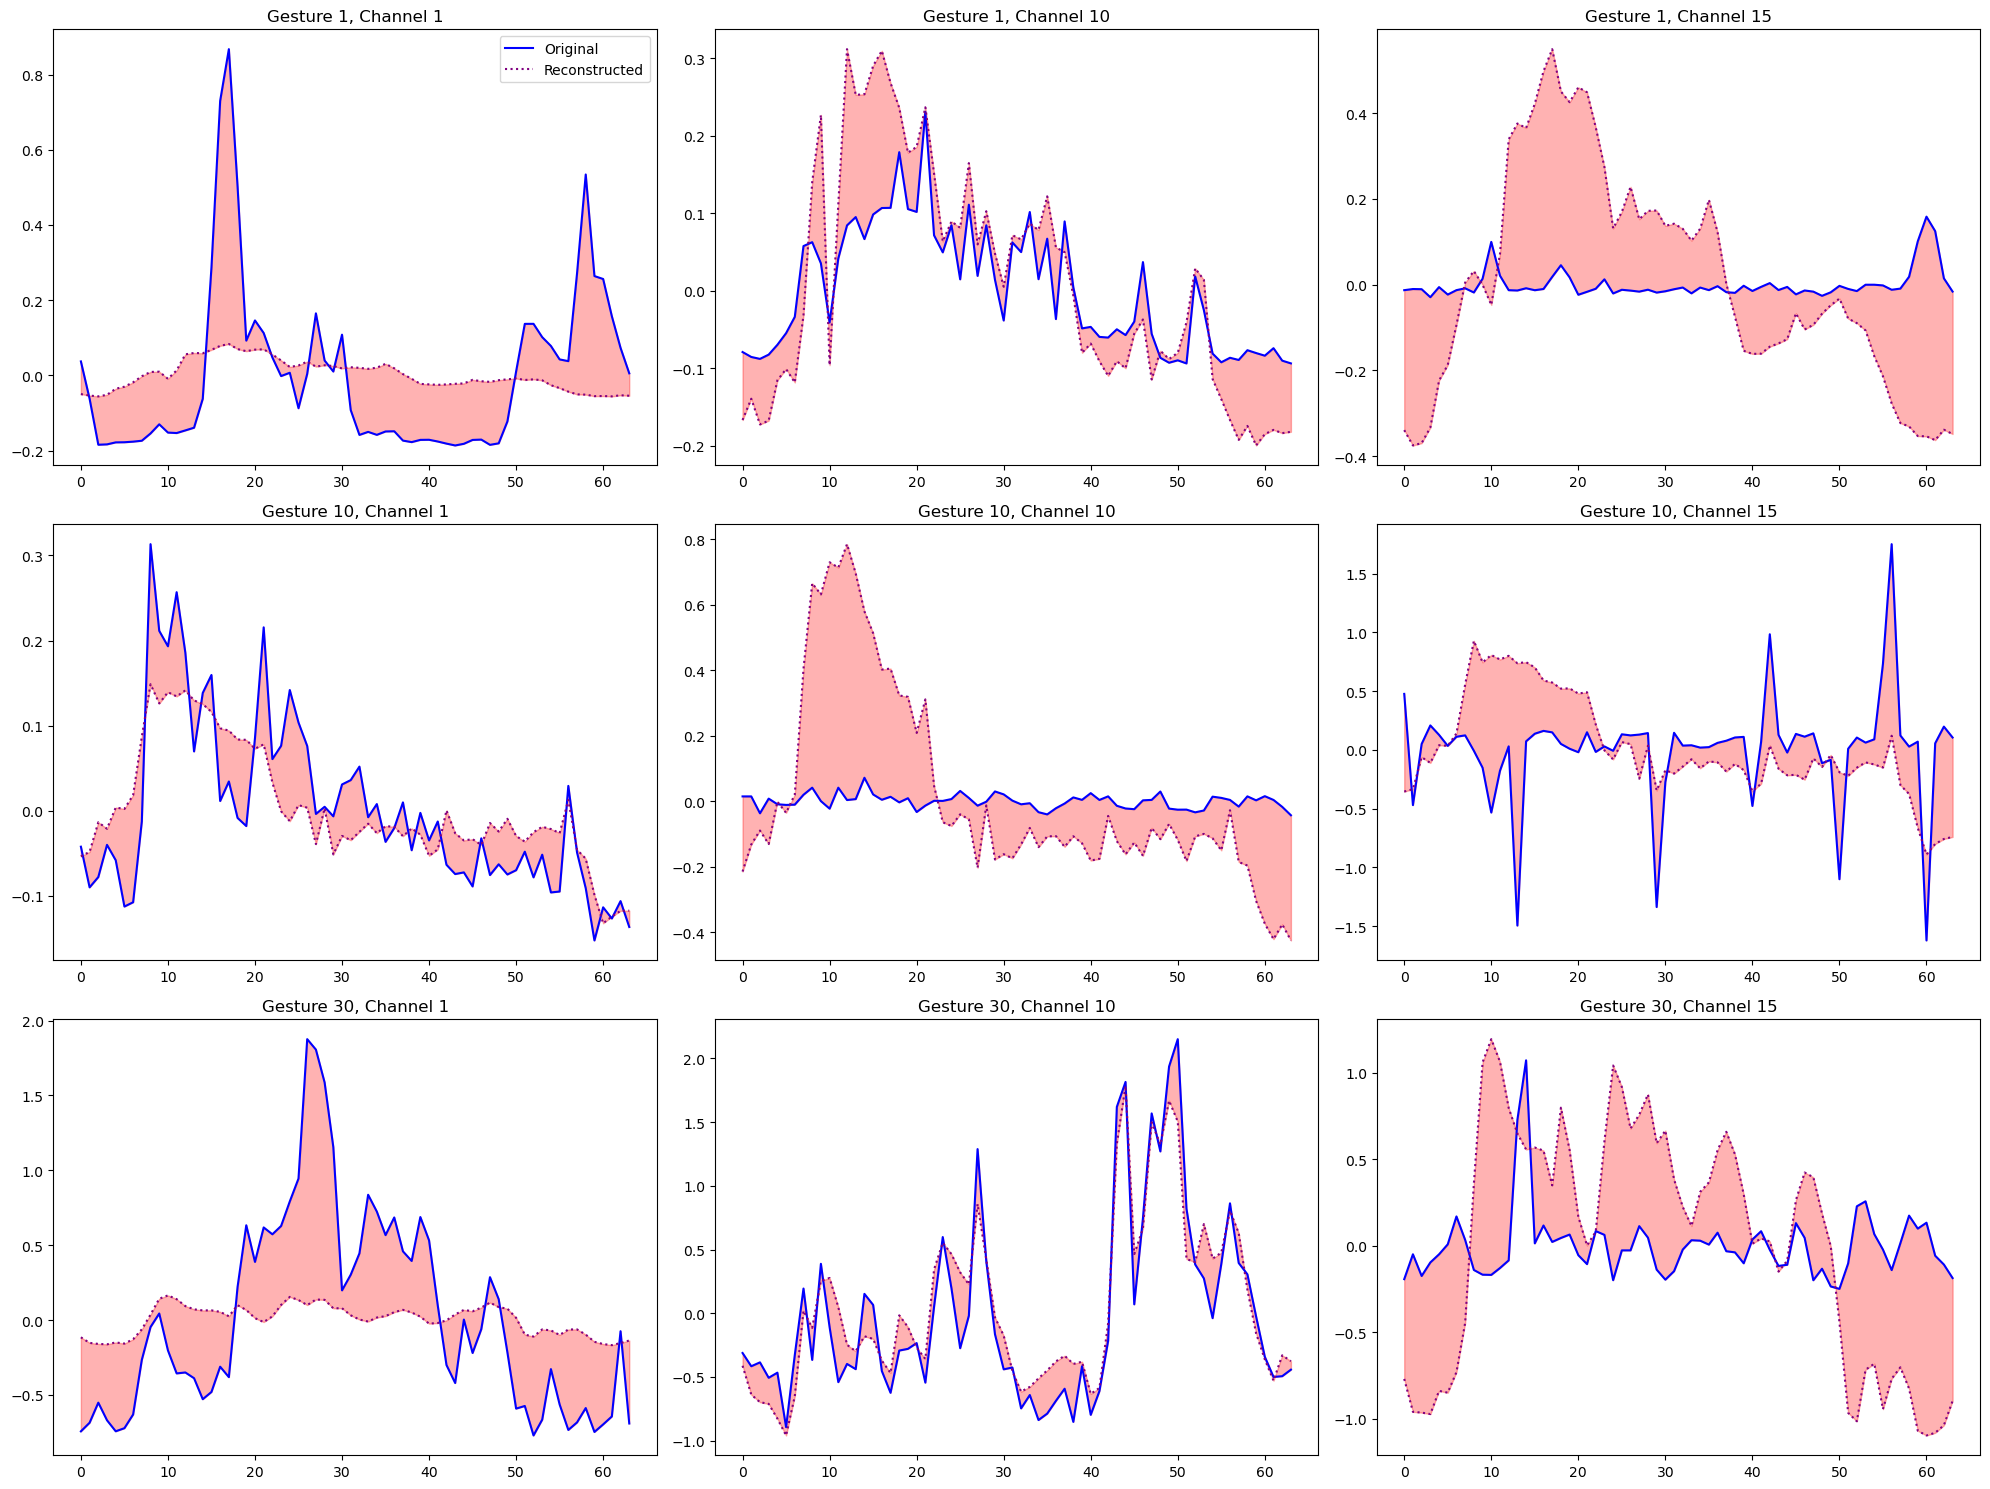

In [27]:
train_batch0 = next(iter(train_loader))
reconstruct_trainbatch0 = model_12_6mir.forward(train_batch0).detach().numpy()

visualize_original_vs_reconstructed_gestures(train_batch0, reconstruct_trainbatch0, selected_channels=[1,10,15]) #selected_gestures,

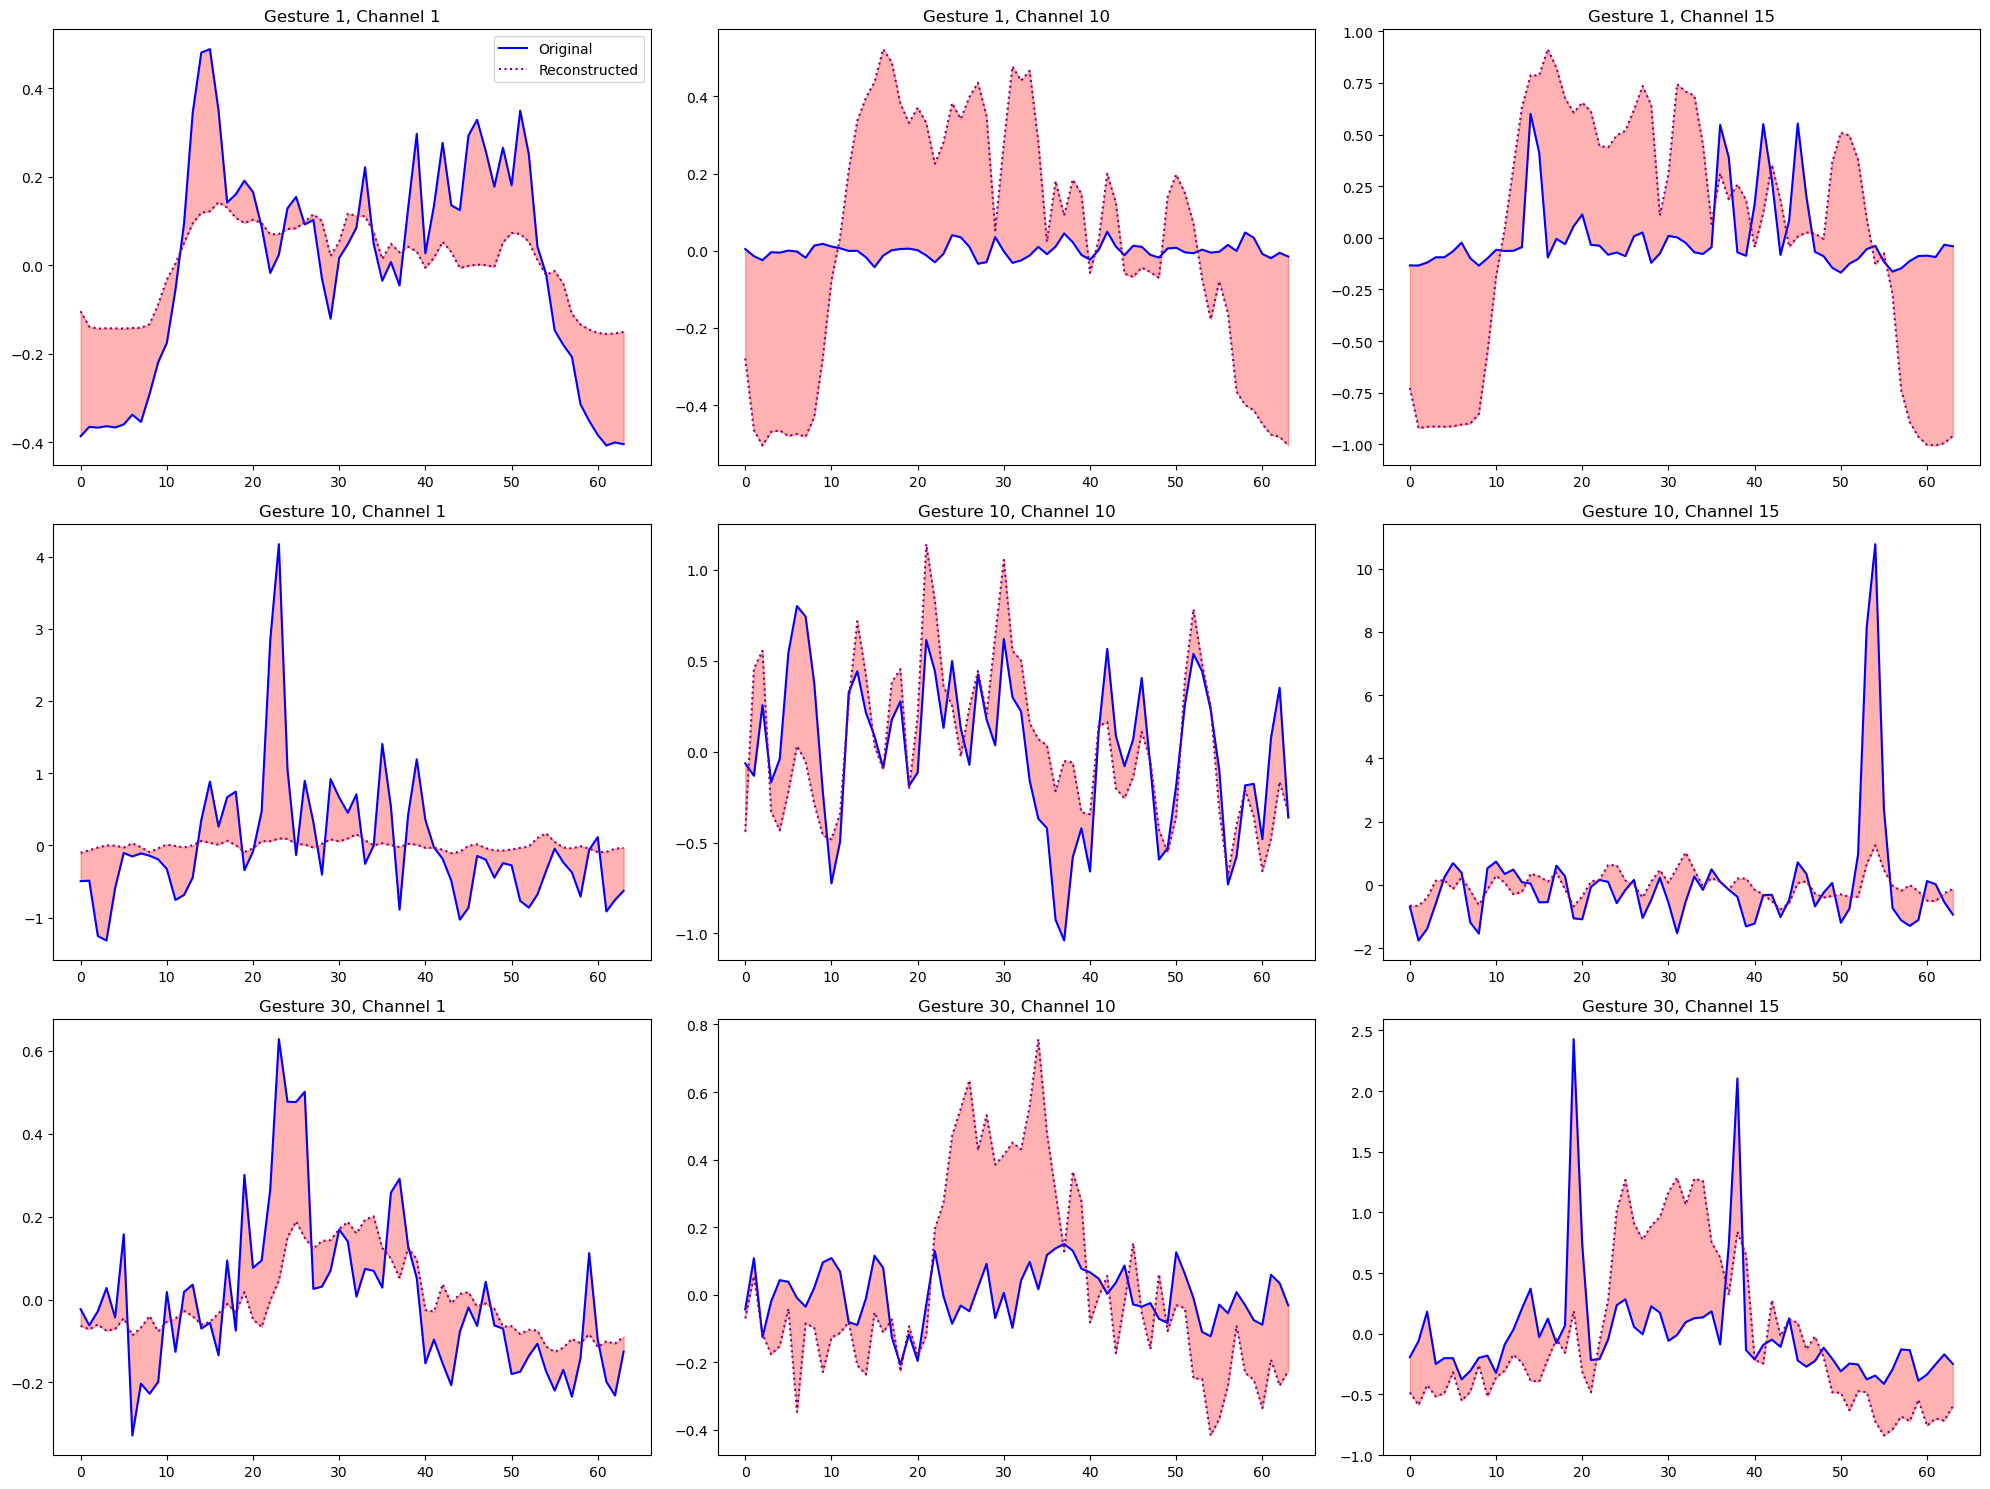

In [28]:
test_batch0 = next(iter(test_loader))
reconstruct_testbatch0 = model_12_6mir.forward(test_batch0).detach().numpy()

visualize_original_vs_reconstructed_gestures(test_batch0, reconstruct_testbatch0, selected_channels=[1,10,15]) #selected_gestures,

In [17]:
assert(False)

AssertionError: 

Save a few of the above models

In [ ]:
torch.save(model_20_14_7_3mir .state_dict(), 'C:\\Users\\YamagamiLab\\Desktop\\Dev\\fl-gestures\\models\\Embedding\\Autoencoders\\RNNAE_20_14_7_3mir_vallossp540_EMGFull.pth')
torch.save(model_9mir .state_dict(), 'C:\\Users\\YamagamiLab\\Desktop\\Dev\\fl-gestures\\models\\Embedding\\Autoencoders\\RNNAE_9mir_vallossp277_EMGFull.pth')
torch.save(model_12_6mir .state_dict(), 'C:\\Users\\YamagamiLab\\Desktop\\Dev\\fl-gestures\\models\\Embedding\\Autoencoders\\RNNAE_12_6mir_vallossp380_EMGFull.pth')